### Jupyter notebook to examine robustness and speed
This notebook re-examines the simple voltage-based method for estimating SOC -- this time as a way to improve robustness of dual or joint filtering -- and also shows how to use simple 1-state SPKFs to estimate R0 and Q using information provided by a standard SPKF.

### Part 1: Determine SOC-estimate bias of simple voltage-based SOC-estimation method
This first part looks at the voltage-based SOC-estimation method. You will want to determine the mean SOC estimation error.

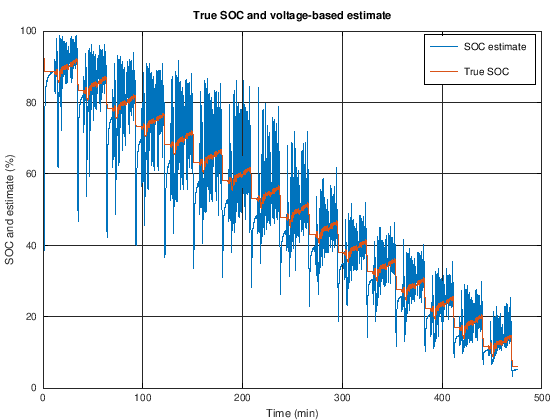

In [1]:
% Voltage-based SOC estimate
addpath readonly
load('readonly/lesson455data.mat');   % load profile of current/voltage/soc versus time
load('readonly/lesson455model.mat');  % load ESC cell model
T = 25;                               % temperature in degC
R0=getParamESC('R0param',T,model);    % get "truth" resistance

socEstimate = SOCfromOCVtemp(voltage+current*R0,25,model); % compute approximate SOC
socError = soc - socEstimate;         % compute SOC-estimation error

% SOC estimate plot
t = 0:length(socEstimate)-1; t = t/60;
plot(t,100*socEstimate, t,100*soc);
title('True SOC and voltage-based estimate');
xlabel('Time (min)'); ylabel('SOC and estimate (%)');
legend('SOC estimate','True SOC'); grid on;

In [14]:
% Enter your own code here to compute value needed for quiz
100*mean(-socError./soc)

ans = -3.1806


### Part 2: SPKF to estimate R0 and Q (added to standard SPKF)
The next blocks of code add parameter estimators to a standard SPKF to estimate R0 and Q. This is neither joint estimation nor dual estimation since the parameter estimates are not fed back to the primary estimator. However, this code shows that it is possible to augment a standard SPKF with simple 1-state SPKFs to make good estimates.

Note that the method for adapting Q "works" in the following sense: If you initialize Qhat at a value greater than the actual capacity, the code adapts Qhat (very) slowly downward; if you initialize Qhat at a value less than the actual capacity, the code adapts Qhat (very) slowly upward. Capacity cannot be adapted quickly because it is so close to unobservable. 

In [3]:
% This function initializes the SPKF. It is the same as you have seen before, except for new code
% at the end of the function to initialize the 1-state SPKFs for R0 and Q
function spkfData = initSPKF(v0,T0,SigmaX0,SigmaV,SigmaW,SigmaR0,SigmaWR0,SigmaQ,SigmaWQ,model)

  % Initial state description
  ir0   = 0;                           spkfData.irInd = 1;
  hk0   = 0;                           spkfData.hkInd = 2;
  SOC0  = SOCfromOCVtemp(v0,T0,model); spkfData.zkInd = 3;
  spkfData.xhat  = [ir0 hk0 SOC0]'; % initial state

  % Covariance values
  spkfData.SigmaX = SigmaX0;
  spkfData.SigmaV = SigmaV;
  spkfData.SigmaW = SigmaW;
  spkfData.Snoise = real(chol(diag([SigmaW; SigmaV]),'lower'));
  spkfData.Qbump = 5;
  
  % SPKF specific parameters
  Nx = length(spkfData.xhat); spkfData.Nx = Nx; % state-vector length
  Ny = 1; spkfData.Ny = Ny; % measurement-vector length
  Nu = 1; spkfData.Nu = Nu; % input-vector length
  Nw = size(SigmaW,1); spkfData.Nw = Nw; % process-noise-vector length
  Nv = size(SigmaV,1); spkfData.Nv = Nv; % sensor-noise-vector length
  Na = Nx+Nw+Nv; spkfData.Na = Na;     % augmented-state-vector length
  
  h = sqrt(3); 
  spkfData.h = h; % SPKF/CDKF tuning factor  
  Weight1 = (h*h-Na)/(h*h); % weighting factors when computing mean
  Weight2 = 1/(2*h*h);      % and covariance
  spkfData.Wm = [Weight1; Weight2*ones(2*Na,1)]; % mean
  spkfData.Wc = spkfData.Wm;                     % covar

  % previous value of current
  spkfData.priorI = 0;
  spkfData.signIk = 0;
  
  % store model data structure too
  spkfData.model = model;
  
  % Now, set data for simple R0 and Q estimators
  spkfData.R0hat = getParamESC('R0Param',T0,model); % "True" R0 that we want to estimate
  spkfData.R0hat = spkfData.R0hat/2; % initialize badly on purpose to see adaptation
  spkfData.SigmaR0 = SigmaR0; % initial uncertainty of R0
  spkfData.SigmaWR0 = SigmaWR0; % covariance of fictitious "noise" driving R0 update
  Weight1 = (h*h-1)/(h*h); % weighting factors when computing mean
  Weight2 = 1/(2*h*h);     % and covariance
  spkfData.R0m = [Weight1; Weight2; Weight2];
  spkfData.R0c = spkfData.R0m; % covar  
  
  spkfData.Qhat = getParamESC('QParam',T0,model); % "True" Q that we want to estimate
  spkfData.Qhat = spkfData.Qhat*.95; % initialize badly on purpose...
  spkfData.SigmaQ = SigmaQ; % initial uncertainty of Q
  spkfData.SigmaWQ = SigmaWQ; % covariance of fictitious "noise" driving Q update
  spkfData.Qm = spkfData.R0m; % weighting factors when computing mean
  spkfData.Qc = spkfData.Qm;  % and covariance 
end

In [12]:
% This is the SPKF iteration code you saw in course 3, except that it now also includes 1-state SPKFs to 
% estimate R0 and Q... see code segments delimited by "****" below...
function [zk,zkbnd,spkfData] = iterSPKF(vk,ik,Tk,deltat,spkfData)
  model = spkfData.model;

  % Load the cell model parameters
  Q  = getParamESC('QParam',Tk,model);
  G  = getParamESC('GParam',Tk,model);
  M  = getParamESC('MParam',Tk,model);
  M0 = getParamESC('M0Param',Tk,model);
  RC = exp(-deltat./abs(getParamESC('RCParam',Tk,model)))';
  R  = getParamESC('RParam',Tk,model)';
  R0 = getParamESC('R0Param',Tk,model);
  eta = getParamESC('etaParam',Tk,model);
  if ik<0, ik=ik*eta; end;
  
  % Get data stored in spkfData structure
  I = spkfData.priorI;
  SigmaX = spkfData.SigmaX;
  xhat = spkfData.xhat;
  Nx = spkfData.Nx;
  Nw = spkfData.Nw;
  Nv = spkfData.Nv;
  Na = spkfData.Na;
  Snoise = spkfData.Snoise;
  Wc = spkfData.Wc;
  irInd = spkfData.irInd;
  hkInd = spkfData.hkInd;
  zkInd = spkfData.zkInd;
  if abs(ik)>Q/100, spkfData.signIk = sign(ik); end;
  signIk = spkfData.signIk;
  priorzk = spkfData.xhat(zkInd);

  % Step 1a: State estimate time update
  %          - Create xhatminus augmented SigmaX points
  %          - Extract xhatminus state SigmaX points
  %          - Compute weighted average xhatminus(k)

  % Step 1a-1: Create augmented SigmaX and xhat
  [sigmaXa,p] = chol(SigmaX,'lower'); 
  if p>0,
    fprintf('Cholesky error.  Recovering...\n');
    theAbsDiag = abs(diag(SigmaX));
    sigmaXa = diag(max(SQRT(theAbsDiag),SQRT(spkfData.SigmaW)));
  end
  sigmaXa=[real(sigmaXa) zeros([Nx Nw+Nv]); zeros([Nw+Nv Nx]) Snoise];
  xhata = [xhat; zeros([Nw+Nv 1])];
  % NOTE: sigmaXa is lower-triangular

  % Step 1a-2: Calculate SigmaX points (strange indexing of xhata to 
  % avoid "repmat" call, which is very inefficient in MATLAB)
  Xa = xhata(:,ones([1 2*Na+1])) + ...
       spkfData.h*[zeros([Na 1]), sigmaXa, -sigmaXa];

  % Step 1a-3: Time update from last iteration until now
  %     stateEqn(xold,current,xnoise)
  Xx = stateEqn(Xa(1:Nx,:),I,Xa(Nx+1:Nx+Nw,:)); 
  xhat = Xx*spkfData.Wm;

  % Step 1b: Error covariance time update
  %          - Compute weighted covariance sigmaminus(k)
  %            (strange indexing of xhat to avoid "repmat" call)
  Xs = Xx - xhat(:,ones([1 2*Na+1]));
  SigmaX = Xs*diag(Wc)*Xs';
  
  % Step 1c: Output estimate
  %          - Compute weighted output estimate yhat(k)
  I = ik; yk = vk;
  Y = outputEqn(Xx,I,Xa(Nx+Nw+1:end,:),Tk,model);
  yhat = Y*spkfData.Wm;

  % Step 2a: Estimator gain matrix
  Ys = Y - yhat(:,ones([1 2*Na+1]));
  SigmaXY = Xs*diag(Wc)*Ys';
  SigmaY = Ys*diag(Wc)*Ys';
  L = SigmaXY/SigmaY; 

  % Step 2b: State estimate measurement update
  r = yk - yhat; % residual.  Use to check for sensor errors...
  if r^2 > 100*SigmaY, L(:,1)=0.0; end 
  xhat = xhat + L*r; 
  xhat(zkInd)=min(1.05,max(-0.05,xhat(zkInd)));
  xhat(hkInd) = min(1,max(-1,xhat(hkInd)));

  % Step 2c: Error covariance measurement update
  SigmaX = SigmaX - L*SigmaY*L';
  [~,S,V] = svd(SigmaX);
  HH = V*S*V';
  SigmaX = (SigmaX + SigmaX' + HH + HH')/4; % Help maintain robustness
  
  % Q-bump code
  if r^2>4*SigmaY, % bad voltage estimate by 2-SigmaX, bump Q 
    fprintf('Bumping sigmax\n');
    SigmaX(zkInd,zkInd) = SigmaX(zkInd,zkInd)*spkfData.Qbump;
  end
  
  % **** Now, implement simple 1-state parameter-estimation SPKF to estimate R0 ****  
    % Implement SPKF for R0hat
    % Step 1a -- R0hat prediction = R0hat estimate... no code needed
    % Step 1b -- R0hat covariance update
    spkfData.SigmaR0 = spkfData.SigmaR0 + spkfData.SigmaWR0;
    % Step 1c -- ouput estimate
    W = spkfData.R0hat*[1 1 1] + sqrt(spkfData.h*spkfData.SigmaR0)*[0 1 -1];
    % Next line is simplified output equation
    D = OCVfromSOCtemp(spkfData.xhat(zkInd),Tk,model)*[1 1 1] -W*ik;
    % Next line is enhanced output equation -- uncomment the next line for two quiz questions!
    D = D + M*xhat(hkInd) - R*xhat(irInd);
    Dhat = D*spkfData.R0m;
    % Step 2a -- gain estimate 
    Ds = D - Dhat;
    Ws = W - spkfData.R0hat;
    Sd = Ds*diag(spkfData.R0c)*Ds' + spkfData.SigmaV; % linear sensor noise
    Swd = Ws*diag(spkfData.R0c)*Ds';
    L = Swd/Sd;
    % Step 2b -- R0 estimate measurement update
    spkfData.R0hat = spkfData.R0hat + L*(vk - Dhat);
    % Step 2c -- R0 estimatation error covariance
    spkfData.SigmaR0 = spkfData.SigmaR0 - L*Sd*L';
  % **** end of simple 1-state SPKF to estimate R0 ****    
  
  % **** Now, implement simple 1-state parameter-estimation SPKF to estimate Q ****  
    % Implement SPKF for Qhat
    % Step 1a -- Qhat prediction = Qhat estimate... no code needed
    % Step 1b -- Qhat covariance update
    spkfData.SigmaQ = spkfData.SigmaQ + spkfData.SigmaWQ;
    % Step 1c -- ouput estimate
    W = spkfData.Qhat*[1 1 1] + sqrt(spkfData.h*spkfData.SigmaQ)*[0 1 -1];
    % Next line is constructed output equation
    D = xhat(zkInd) - priorzk + spkfData.priorI*deltat./(3600*W);
    Dhat = D*spkfData.Qm;
    % Step 2a -- gain estimate 
    Ds = D - Dhat;
    Ws = W - spkfData.Qhat;
    Sd = Ds*diag(spkfData.Qc)*Ds' + spkfData.SigmaV; % linear sensor noise
    Swd = Ws*diag(spkfData.Qc)*Ds';
    L = Swd/Sd;
    % Step 2b -- Q estimate measurement update
    spkfData.Qhat = spkfData.Qhat + L*(0 - Dhat);
    % Step 2c -- Q estimatation error covariance
    spkfData.SigmaQ = spkfData.SigmaQ - L*Sd*L';
  % **** end of simple 1-state SPKF to estimate Q ****    

  % Save data in spkfData structure for next time...
  spkfData.priorI = ik;
  spkfData.SigmaX = SigmaX;
  spkfData.xhat = xhat;
  zk = xhat(zkInd);
  zkbnd = 3*sqrt(SigmaX(zkInd,zkInd));
  
  % Calculate new states for all of the old state vectors in xold.  
  function xnew = stateEqn(xold,current,xnoise)
    current = current + xnoise; % noise adds to current
    xnew = 0*xold;
    xnew(irInd,:) = RC*xold(irInd,:) + (1-diag(RC))*current;
    Ah = exp(-abs(current*G*deltat/(3600*Q)));  % hysteresis factor
    xnew(hkInd,:) = Ah.*xold(hkInd,:) + (Ah-1).*sign(current);
    xnew(zkInd,:) = xold(zkInd,:) - current/3600/Q;
    xnew(hkInd,:) = min(1,max(-1,xnew(hkInd,:)));
    xnew(zkInd,:) = min(1.05,max(-0.05,xnew(zkInd,:)));
  end

  % Calculate cell output voltage for all of state vectors in xhat
  function yhat = outputEqn(xhat,current,ynoise,T,model)
    yhat = OCVfromSOCtemp(xhat(zkInd,:),T,model);
    yhat = yhat + M*xhat(hkInd,:) + M0*signIk;
    yhat = yhat - R*xhat(irInd,:) - R0*current + ynoise(1,:);
  end

  % "Safe" square root
  function X = SQRT(x)
    X = sqrt(max(0,x));
  end
end

In [13]:
% This code is the "wrapper code" to execute the SPKF
addpath readonly
load('readonly/lesson455data.mat');   % load profile of current/voltage/soc versus time
load('readonly/lesson455model.mat');  % load ESC cell model
T = 25;                               % temperature in degC

% Provide the covariance (uncertainty) tuning matrix for the initial
% state estimate. The ordering of the states in xhat are:
% resistor-current states, then hysteresis state, then SOC.
SigmaX0 = diag([1e-4 1e-4 0.01]); 
% Provide the covariance (uncertainty) tuning matrices SigmaW and
% SigmaV for the initial process noise and sensor noise, respectively.
SigmaW = 1e-2;
SigmaV = 1e-2;

SigmaR0 = 1e-6;   % initial uncertainty of R0
SigmaWR0 = 1e-16; % noise driving R0 update
SigmaQ = 1e-1;    % initial uncertainty of Q
SigmaWQ = 1e-14;  % noise driving Q update

spkfData = initSPKF(voltage(1),T,SigmaX0,SigmaV,SigmaW,SigmaR0,SigmaWR0,SigmaQ,SigmaWQ,model);

zk = zeros(size(voltage)); R0hat = zk; R0bnd = zk; Qhat = zk; Qbnd = zk;
zkbnd = zk; 
deltat = time(2)-time(1);
for k = 1:length(voltage),
  vk = voltage(k); % "measure" voltage
  ik = current(k); % "measure" current
  Tk = T;          % "measure" temperature

  % Update SOC (and other model states)
  [zk(k),zkbnd(k),spkfData] = iterSPKF(vk,ik,Tk,deltat,spkfData);
  
  R0hat(k) = spkfData.R0hat; % also update resistance estimate
  R0bnd(k) = 3*sqrt(spkfData.SigmaR0); 
  Qhat(k)  = spkfData.Qhat;  % and total-capacity estimate
  Qbnd(k)  = 3*sqrt(spkfData.SigmaQ);
  if mod(k,1000)==0,
    fprintf('Iteration %d out of %d complete\n',k,length(voltage));
  end
end

Iteration 1000 out of 28510 complete
Iteration 2000 out of 28510 complete
Iteration 3000 out of 28510 complete
Iteration 4000 out of 28510 complete
Iteration 5000 out of 28510 complete
Iteration 6000 out of 28510 complete
Iteration 7000 out of 28510 complete
Iteration 8000 out of 28510 complete
Iteration 9000 out of 28510 complete
Iteration 10000 out of 28510 complete
Iteration 11000 out of 28510 complete
Iteration 12000 out of 28510 complete
Iteration 13000 out of 28510 complete
Iteration 14000 out of 28510 complete
Iteration 15000 out of 28510 complete
Iteration 16000 out of 28510 complete
Iteration 17000 out of 28510 complete
Iteration 18000 out of 28510 complete
Iteration 19000 out of 28510 complete
Iteration 20000 out of 28510 complete
Iteration 21000 out of 28510 complete
Iteration 22000 out of 28510 complete
Iteration 23000 out of 28510 complete
Iteration 24000 out of 28510 complete
Iteration 25000 out of 28510 complete
Iteration 26000 out of 28510 complete
Iteration 27000 out o

In [15]:
% Enter your own code here to compute values needed for quiz
R0true = getParamESC('R0Param',T,model);
mean(R0true - R0hat)*1000
sqrt(mean((R0true - R0hat).^2))*1000

ans =  0.0056999
ans =  0.063419


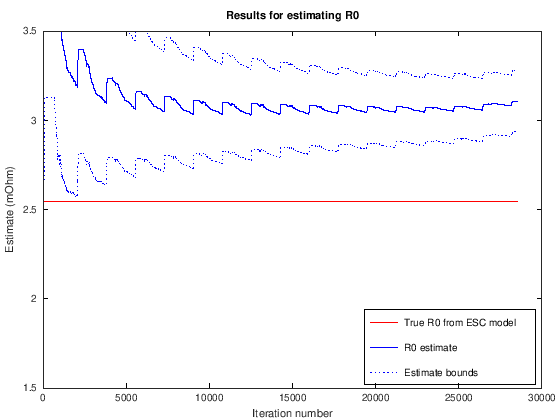

In [7]:
% Plot the R0 estimate results
k = 1:length(voltage); k = k-1; 
R0true = getParamESC('R0Param',T,model);
plot(k,0*k+R0true*1000,'r'); hold on
plot(k,R0hat*1000,'b',k,(R0hat+R0bnd)*1000,'b:',k,(R0hat-R0bnd)*1000,'b:');
legend('True R0 from ESC model','R0 estimate','Estimate bounds','location','southeast');
xlabel('Iteration number'); ylabel('Estimate (mOhm)');
title('Results for estimating R0')
ylim([1.5 3.5]); 

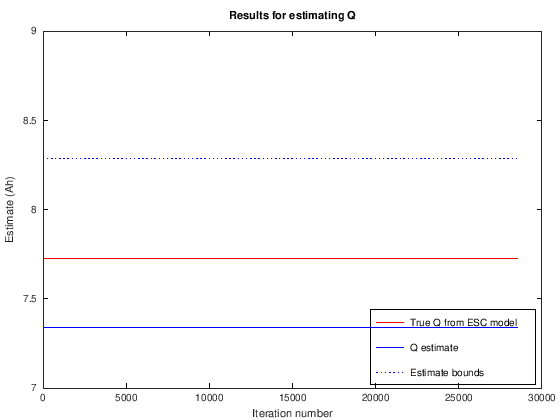

In [8]:
% Plot the Q estimate results
k = 1:length(voltage); k = k-1; 
Qtrue = getParamESC('QParam',T,model);
plot(k,0*k+Qtrue,'r'); hold on
plot(k,Qhat,'b',k,(Qhat+Qbnd),'b:',k,(Qhat-Qbnd),'b:');
legend('True Q from ESC model','Q estimate','Estimate bounds','location','southeast');
xlabel('Iteration number'); ylabel('Estimate (Ah)');
title('Results for estimating Q')
ylim([7 9]); 